# Youtube Trending Exploratory Data Analysis

### Author: Berkeley D. Willis

The data used in the project is from [Kaggle](https://www.kaggle.com/datasnaek/youtube-new), and contains data on the videos that appeared on the Youtube trending feed. This was essentially a basic data analysis and study on the data, with basic observations of the videos that appeared on the trending tabs over a period of time. 

In [1]:
#!/usr/bin/env python
#
# File: final_project.py
# Name: Berkeley D. Willis
# Date: 2020-02-28
# Course: DSC530-T301 - Data Exploration and Analysis
# Desc:  This is the code that was used to render all the graphs and other visuals
#          that are used in the power point and for my conclusions about the
#          Youtube trending data
# Usage: Run this script by directly invoking it with the python interpreter or
#          by having python installed and giving this file execution priveleges
#          It is recommended if you are going to be running each exercise
#          separately that you run this section by section in different instances

# Using functions here for interactive environment as well so I can continue to explore
# easily

################################################################################
# Setting up environment                                                       #
################################################################################

# Loading libraries
from __future__ import print_function, division

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from pandarallel import pandarallel
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 270)

from scipy.stats import poisson

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import statsmodels.formula.api as smf

import random
import json
import gc

pandarallel.initialize()


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Now with the basic models and required libraries, going to create some custom helper functions to clean and join data from the files together.

In [2]:
# Function responsible for loading a single file and it's categories
def loadYTTrendFile(country_code, data_dir="./data/"):
    category_postfix = "_category_id.json"
    videos_postfix = "videos.csv"
    print("  Loading data from csv")
    videos_pd = pd.read_csv(filepath_or_buffer=data_dir + country_code + videos_postfix, encoding='utf_8')
    videos_pd['country_code'] = country_code
    print("  Loading data from json")
    categories_json = json.load(open(data_dir + country_code + category_postfix, 'r'))
    # Going to keep track of them in lists and then make a
    cat_ids = []
    cat_titles = []
    # Current structure requires that we loop over the various items in a json file and pull out what we need
    print("  Parsing json data to pd")
    for item in categories_json['items']:
        # Extract code and the category title and put in a separate df to be merged
        cat_ids.append(item['id'])
        cat_titles.append(item['snippet']['title'])
    # Create dataframe from boths lists, gotta typecast category_id for a merge
    print("  Merging category data to primary dataframe")
    categories_pd = pd.DataFrame({'category_id':cat_ids, 'category': cat_titles})
    categories_pd.category_id = categories_pd.category_id.astype('int64')
    # Do a merge on the two dataframes and return the resulting dataframe
    return videos_pd.merge(categories_pd, how="left", on="category_id")


# Function to simply load all data from files and bind to a single pandas array
def loadYTTrendData(data_dir="./data/"):
    # List of all country codes that will help us build our paths and import data, limited on some of these files because of unexpted non-utf_8 strings
    country_codes = [ "CA", "DE", "FR", "GB", "IN", "US" ]
    # Defaulting value of pd
    ret_pd = None
    for i in range(len(country_codes)):
        print("Attempting to load trend data from: %s" % (country_codes[i]))
        if isinstance(ret_pd, pd.DataFrame):
            ret_pd = ret_pd.append(loadYTTrendFile(country_codes[i], data_dir=data_dir))
        else:
            ret_pd = loadYTTrendFile(country_codes[i], data_dir=data_dir)
    return ret_pd


Now get the data.

In [3]:
# Load the trend data
trend_pd = loadYTTrendData()

# Now have to convert all date and datatime datapoints to their appropriate from
trend_pd.trending_date = pd.to_datetime(trend_pd.trending_date, format="%y.%d.%m")
trend_pd.publish_time  = pd.to_datetime(trend_pd.publish_time,  format="%Y-%m-%dT%H:%M:%S.000Z")

trend_pd = trend_pd.sort_values(by=['country_code', 'trending_date', 'video_id', 'views'], ascending=True, na_position='last')

trend_pd = trend_pd.drop_duplicates(subset=['country_code', 'trending_date', 'video_id'], keep=False).reindex()

################################################################################
# END Setting up environment                                                   #
################################################################################


Attempting to load trend data from: CA
  Loading data from csv
  Loading data from json
  Parsing json data to pd
  Merging category data to primary dataframe
Attempting to load trend data from: DE
  Loading data from csv
  Loading data from json
  Parsing json data to pd
  Merging category data to primary dataframe
Attempting to load trend data from: FR
  Loading data from csv
  Loading data from json
  Parsing json data to pd
  Merging category data to primary dataframe
Attempting to load trend data from: GB
  Loading data from csv
  Loading data from json
  Parsing json data to pd
  Merging category data to primary dataframe
Attempting to load trend data from: IN
  Loading data from csv
  Loading data from json
  Parsing json data to pd
  Merging category data to primary dataframe
Attempting to load trend data from: US
  Loading data from csv
  Loading data from json
  Parsing json data to pd
  Merging category data to primary dataframe


Now going to run those cleaning operations and mining operations to get some other helpful datapoints.

In [4]:
################################################################################
# Mining a few extra datapoints to assist in the analysis                      #
################################################################################

# The more I thought of possible relevant datapoints I had to think about how a time series analysis
# might reveal more things like survival analysis for those videos that are on trending for a while

# Now let's get some possibly useful datapoints, like for one the age of the video at the time of trending
trend_pd["video_age"] = trend_pd.trending_date - trend_pd.publish_time
trend_pd['video_age_days'] = trend_pd.video_age.dt.days

# try to get commond words or subjects in videoo titles, first get words and their counts from video titles
trend_pd['title_clean'] = trend_pd['title'].replace('[^a-zA-Z0-9 ]', '', regex=True).str.lower()
word_aggregation = trend_pd.title_clean.str.split(expand=True).stack().value_counts()
word_aggregation_pd = pd.DataFrame({'word':word_aggregation.index.tolist(), 'count':word_aggregation})

common_tags = trend_pd.tags.str.split("|", expand=True).stack().str.replace('"','').value_counts().reset_index()
# Removing the [none] tag
common_tags = common_tags[ (common_tags['index']!="[none]") ]

# Lets remove some of the words that shouldn't matter, like articles and somewhat redundant terms like video or videos, using list of words, have to consider other languagse as well
# this clears at least the top 50 from being garbage data, this in combination with cateogires can lead to more data mining depending on what we are looking for.
filter_words = [ 'the', 'a', 'an', 'video', 'in', 'of', 'to', 'de', 'with', 'and', 'le', 'et', 'it', 'by'
                 'on', 'vs', 'la', 'les', 'is', 'for', 'at', 'du', 'en', 'this', 'that' ]
# Get stuff that isn't in that list
word_aggregation_pd = word_aggregation_pd[ word_aggregation_pd.word.isin(filter_words)==False ]

# Value counts of the categories and how they breakdown
category_breakdown = trend_pd.category.value_counts()

# Defaulting new values pre-imptiveiy with np.nan
trend_pd['views_delta'] = np.nan
trend_pd['likes_delta'] = np.nan
trend_pd['dislikes_delta'] = np.nan
trend_pd['comment_count_delta'] = np.nan

# I hope this is passing by reference/pointer because otherwise this might be very expensive memorywise

# Function takes a data frame for each video_id and a dataframe for the past, and will attempt to find the latest entry for the same video_id and calculate the current - past values
def mineDeltaPerVideo(video_id, current_pd, prev_pd, field_name):
    # print("    Mining for video: {0}".format(video_id))
    if not video_id in prev_pd.video_id.to_list():
        return np.nan
    return int(current_pd[ (current_pd.video_id==video_id) ][field_name]) - int(prev_pd[ (prev_pd.video_id==video_id) & (prev_pd.trending_date == prev_pd[ prev_pd.video_id==video_id ].trending_date.max()) ][field_name])

# This will take a date a dataframe and apply the mineDeltaPerVideo function for each video_id found
def minePerDate(trend_date, arg_pd, field_name):
    # print("  Mining Date {0} for {1}".format(trend_date, field_name))
    return arg_pd[ (arg_pd.trending_date==trend_date) ].video_id.apply(mineDeltaPerVideo, current_pd=arg_pd[ (arg_pd.trending_date==trend_date) ],
                                prev_pd=arg_pd[ (arg_pd.trending_date < trend_date) & (arg_pd.video_id.isin(arg_pd[ (arg_pd.trending_date==trend_date) ].video_id)) ], field_name=field_name).tolist()

# Function will take a dataframe with multiple trending dates, limit the dataframe by the country and apply the minePerDate function for each trending_date
def minePerCountry(country_code, arg_pd, field_name):
    print("Mining Country {0} for {1}".format(country_code, field_name))
    country_list = []
    temp_series = pd.Series(arg_pd[ (arg_pd.country_code==country_code) ].trending_date.unique()).parallel_apply(minePerDate, arg_pd=arg_pd[ (arg_pd.country_code==country_code) ], field_name=field_name)
    for series in temp_series:
        country_list.extend(series)
    return {'country_code':country_code, 'new_list':country_list}

# Getting series of lists for each country, this will also help us identify more easily those videos that appear in a countries trending more than once
views_series     = pd.Series(trend_pd.country_code.unique()).apply(minePerCountry, arg_pd=trend_pd, field_name="views")
likes_series     = pd.Series(trend_pd.country_code.unique()).apply(minePerCountry, arg_pd=trend_pd, field_name="likes")
dislikes_series  = pd.Series(trend_pd.country_code.unique()).apply(minePerCountry, arg_pd=trend_pd, field_name="dislikes")
comment_c_series = pd.Series(trend_pd.country_code.unique()).apply(minePerCountry, arg_pd=trend_pd, field_name="comment_count")

# Confirm that our data is in order of trending date and then loop through each list to re-assign data
for item in views_series.iteritems():
    tmp_item = item[1]
    trend_pd.loc[ (trend_pd.country_code==tmp_item['country_code']), 'views_delta']         = tmp_item['new_list']

for item in likes_series.iteritems():
    tmp_item = item[1]
    trend_pd.loc[ (trend_pd.country_code==tmp_item['country_code']), 'likes_delta']         = tmp_item['new_list']

for item in dislikes_series.iteritems():
    tmp_item = item[1]
    trend_pd.loc[ (trend_pd.country_code==tmp_item['country_code']), 'dislikes_delta']      = tmp_item['new_list']

for item in comment_c_series.iteritems():
    tmp_item = item[1]
    trend_pd.loc[ (trend_pd.country_code==tmp_item['country_code']), 'comment_count_delta'] = tmp_item['new_list']

# Going to calculate the amount of time a video spends in trending
min_time_trending_pd = trend_pd.groupby(['country_code','video_id']).trending_date.min().to_frame().reset_index().rename(columns={"trending_date":"origin_date"})
trend_pd = trend_pd.merge(min_time_trending_pd, how="left", on=['country_code', 'video_id'])
trend_pd['days_trending'] = (trend_pd.trending_date - trend_pd.origin_date).dt.days


################################################################################
# END Mining a few extra datapoints to assist in the analysis                  #
################################################################################


Mining Country CA for views
Mining Country DE for views
Mining Country FR for views
Mining Country GB for views
Mining Country IN for views
Mining Country US for views
Mining Country CA for likes
Mining Country DE for likes
Mining Country FR for likes
Mining Country GB for likes
Mining Country IN for likes
Mining Country US for likes
Mining Country CA for dislikes
Mining Country DE for dislikes
Mining Country FR for dislikes
Mining Country GB for dislikes
Mining Country IN for dislikes
Mining Country US for dislikes
Mining Country CA for comment_count
Mining Country DE for comment_count
Mining Country FR for comment_count
Mining Country GB for comment_count
Mining Country IN for comment_count
Mining Country US for comment_count


After gather all these other helpful datapoints, now to do some basic visualizations on the relationships between the datapoints.

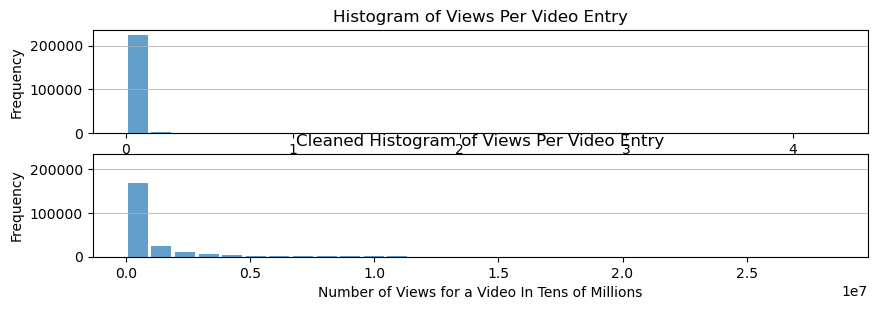

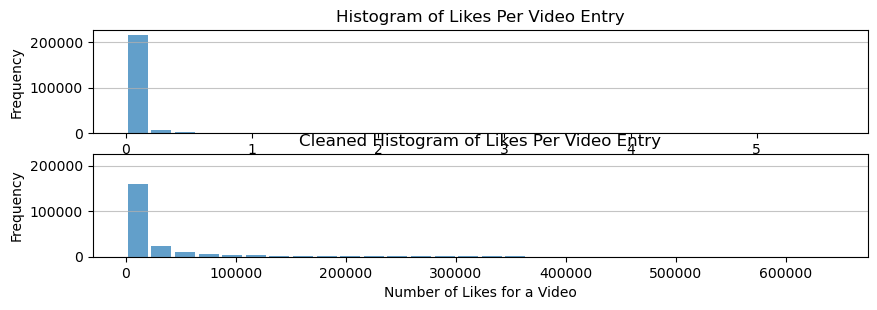

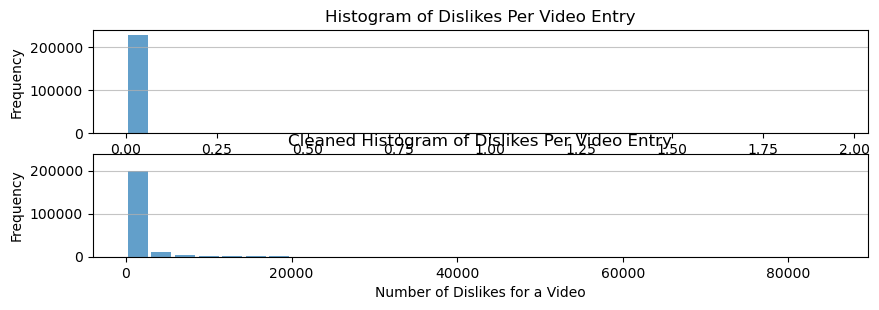

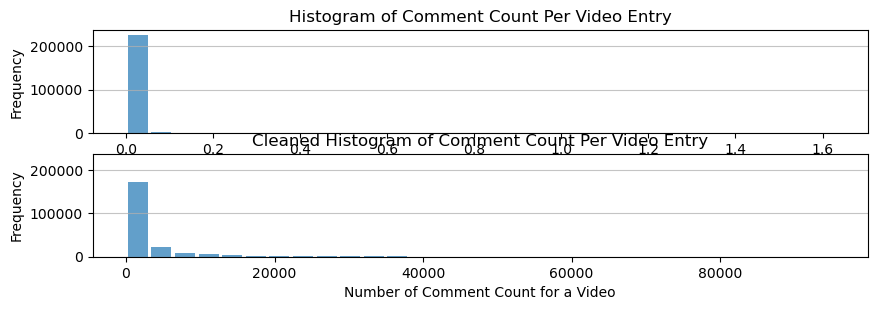

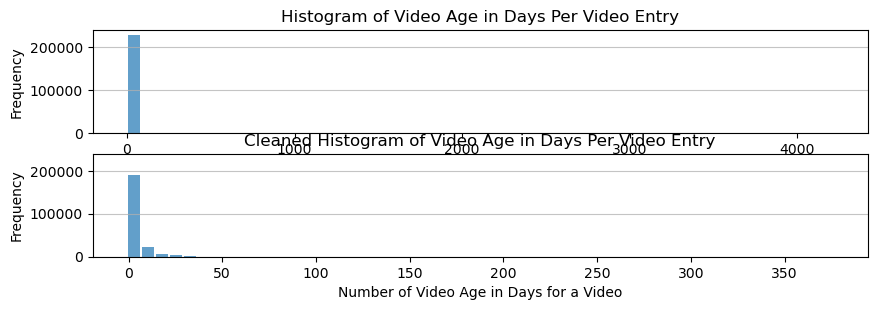

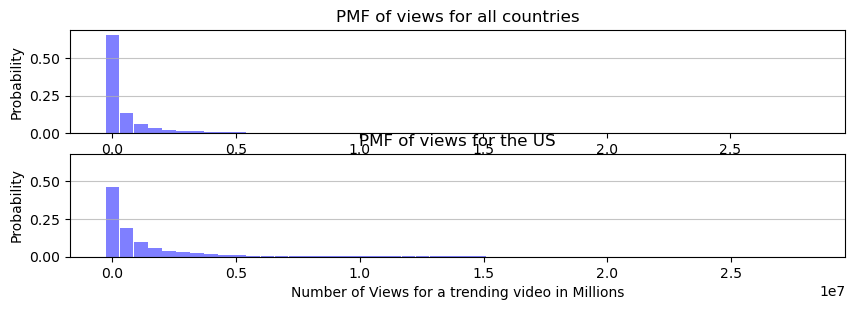

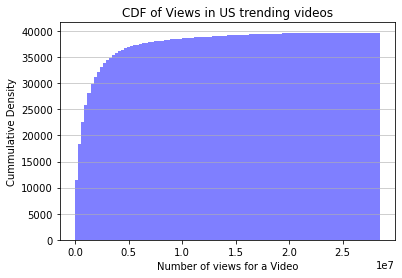

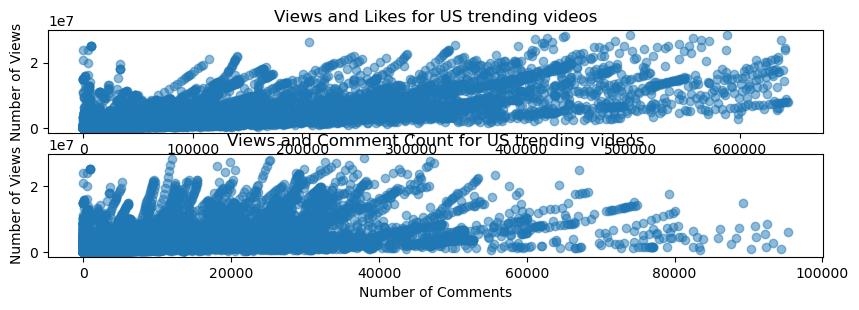

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  views   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                 1.197e+05
Date:                Thu, 13 May 2021   Prob (F-statistic):               0.00
Time:                        01:01:36   Log-Likelihood:            -3.5106e+06
No. Observations:              224788   AIC:                         7.021e+06
Df Residuals:                  224783   BIC:                         7.021e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.126e+05   3544.719     31.758      0.000    1.06e+05     1.2e+05
likes             26.2963      0.073    362.061      0.000      26.154      26.439
dislikes         159.8984      0.914    174.992      0.000     158.107     161.689
comment_count    -60.1904      0.720    -83.589      0.000     -61.602     -58.779
video_age_days  3.206e+04    365.585     87.689      0.000    3.13e+04    3.28e+04
==============================================================================
Omnibus:                   176999.110   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13828679.257
Skew:                           3.230   Prob(JB):                         0.00
Kurtosis:                      40.878   Cond. No.                     9.38e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [5]:
################################################################################
# Required project visualizations and variable analysis                        #
################################################################################

# Calculate zscore for each column we will inspect
trend_pd['views_zscore'] = (trend_pd['views'] - trend_pd['views'].mean())/trend_pd['views'].std(ddof=0)
trend_pd['likes_zscore'] = (trend_pd['likes'] - trend_pd['likes'].mean())/trend_pd['likes'].std(ddof=0)
trend_pd['dislikes_zscore'] = (trend_pd['dislikes'] - trend_pd['dislikes'].mean())/trend_pd['dislikes'].std(ddof=0)
trend_pd['comment_n_zscore'] = (trend_pd['comment_count'] - trend_pd['comment_count'].mean())/trend_pd['comment_count'].std(ddof=0)
trend_pd['video_age_days_zscore'] = (trend_pd['video_age_days'] - trend_pd['video_age_days'].mean())/trend_pd['video_age_days'].std(ddof=0)

# Getting some basic meta data about all 5 variables for the project
trend_pd.views.describe()
trend_pd.views.mode()

trend_pd.likes.describe()
trend_pd.likes.mode()

trend_pd.dislikes.describe()
trend_pd.dislikes.mode()

trend_pd.comment_count.describe()
trend_pd.comment_count.mode()

trend_pd.video_age_days.describe()
trend_pd.video_age_days.mode()

# Now going to limit ourselve to another set of data where we take into account the z-score for each field
clean_trend_pd = trend_pd[ (abs(trend_pd.views_zscore) < 3) & (abs(trend_pd.likes_zscore) < 3) & (abs(trend_pd.dislikes_zscore) < 3) & (abs(trend_pd.comment_n_zscore) < 3) & (abs(trend_pd.video_age_days_zscore) < 3) ]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 3), sharey=True, dpi=100)

# For views
ax1.hist(trend_pd.views, bins=30, alpha=0.7, rwidth=0.85)
ax1.set_title("Histogram of Views Per Video Entry")
ax1.set_xlabel("Number of Views for a Video In Tens of Millions")
ax1.set_ylabel("Frequency")
ax1.grid(axis='y', alpha=0.75)

ax2.hist(clean_trend_pd.views, bins=30, alpha=0.7, rwidth=0.85)
ax2.set_title("Cleaned Histogram of Views Per Video Entry")
ax2.set_xlabel("Number of Views for a Video In Tens of Millions")
ax2.set_ylabel("Frequency")
ax2.grid(axis='y', alpha=0.75)

plt.show()



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 3), sharey=True, dpi=100)

# For likes
ax1.hist(trend_pd.likes, bins=30, alpha=0.7, rwidth=0.85)
ax1.set_title("Histogram of Likes Per Video Entry")
ax1.set_xlabel("Number of Likes for a Video")
ax1.set_ylabel("Frequency")
ax1.grid(axis='y', alpha=0.75)

ax2.hist(clean_trend_pd.likes, bins=30, alpha=0.7, rwidth=0.85)
ax2.set_title("Cleaned Histogram of Likes Per Video Entry")
ax2.set_xlabel("Number of Likes for a Video")
ax2.set_ylabel("Frequency")
ax2.grid(axis='y', alpha=0.75)

plt.show()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 3), sharey=True, dpi=100)

# For dislikes
ax1.hist(trend_pd.dislikes, bins=30, alpha=0.7, rwidth=0.85)
ax1.set_title("Histogram of Dislikes Per Video Entry")
ax1.set_xlabel("Number of Dislikes for a Video")
ax1.set_ylabel("Frequency")
ax1.grid(axis='y', alpha=0.75)

ax2.hist(clean_trend_pd.dislikes, bins=30, alpha=0.7, rwidth=0.85)
ax2.set_title("Cleaned Histogram of Dislikes Per Video Entry")
ax2.set_xlabel("Number of Dislikes for a Video")
ax2.set_ylabel("Frequency")
ax2.grid(axis='y', alpha=0.75)

plt.show()



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 3), sharey=True, dpi=100)

# For comment_count
ax1.hist(trend_pd.comment_count, bins=30, alpha=0.7, rwidth=0.85)
ax1.set_title("Histogram of Comment Count Per Video Entry")
ax1.set_xlabel("Number of Comment Count for a Video")
ax1.set_ylabel("Frequency")
ax1.grid(axis='y', alpha=0.75)

ax2.hist(clean_trend_pd.comment_count, bins=30, alpha=0.7, rwidth=0.85)
ax2.set_title("Cleaned Histogram of Comment Count Per Video Entry")
ax2.set_xlabel("Number of Comment Count for a Video")
ax2.set_ylabel("Frequency")
ax2.grid(axis='y', alpha=0.75)

plt.show()



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 3), sharey=True, dpi=100)

# For video_age_days
ax1.hist(trend_pd.video_age_days, bins=50, alpha=0.7, rwidth=0.85)
ax1.set_title("Histogram of Video Age in Days Per Video Entry")
ax1.set_xlabel("Number of Video Age in Days for a Video")
ax1.set_ylabel("Frequency")
ax1.grid(axis='y', alpha=0.75)

ax2.hist(clean_trend_pd.video_age_days, bins=50, alpha=0.7, rwidth=0.85)
ax2.set_title("Cleaned Histogram of Video Age in Days Per Video Entry")
ax2.set_xlabel("Number of Video Age in Days for a Video")
ax2.set_ylabel("Frequency")
ax2.grid(axis='y', alpha=0.75)

plt.show()



# PMFs for both cleaned views and the views from the US
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 3), sharey=True, dpi=100)

heights,bins = np.histogram(clean_trend_pd.views,bins=50)
heights = heights/sum(heights)
ax1.bar(bins[:-1],heights,width=(max(bins) - min(bins))/len(bins), color="blue", alpha=0.5)
ax1.set_title("PMF of views for all countries")
ax1.set_xlabel("Number of Views for a trending video in Millions")
ax1.set_ylabel("Probability")
ax1.grid(axis='y', alpha=0.75)

heights,bins = np.histogram(clean_trend_pd[ clean_trend_pd.country_code=="US" ].views,bins=50)
heights = heights/sum(heights)
ax2.bar(bins[:-1],heights,width=(max(bins) - min(bins))/len(bins), color="blue", alpha=0.5)
ax2.set_title("PMF of views for the US")
ax2.set_xlabel("Number of Views for a trending video in Millions")
ax2.set_ylabel("Probability")
ax2.grid(axis='y', alpha=0.75)

plt.show()


# CDF of the views of trending videos in the US
plt.hist(clean_trend_pd[ clean_trend_pd.country_code=="US" ].views.sort_values(), cumulative=True, color="blue", alpha=0.5, bins=100)
plt.title("CDF of Views in US trending videos")
plt.xlabel("Number of views for a Video")
plt.ylabel("Cummulative Density")
plt.grid(axis='y', alpha=0.75)
plt.show()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 3), sharey=True, dpi=100)

# Scatter plot of trending videos in the US with views and likes
ax1.scatter(clean_trend_pd[ clean_trend_pd.country_code=="US" ].likes, clean_trend_pd[ clean_trend_pd.country_code=="US" ].views, alpha=0.5)
ax1.set_title("Views and Likes for US trending videos")
ax1.set_xlabel("Number of Likes")
ax1.set_ylabel("Number of Views")

ax2.scatter(clean_trend_pd[ clean_trend_pd.country_code=="US" ].comment_count, clean_trend_pd[ clean_trend_pd.country_code=="US" ].views, alpha=0.5)
ax2.set_title("Views and Comment Count for US trending videos")
ax2.set_xlabel("Number of Comments")
ax2.set_ylabel("Number of Views")

plt.show()

# Corrlelation between views and other relevant vars
clean_trend_pd[['views', 'likes', 'comment_count']].corr()


# Modeling using smf starts here
views_formula = "views ~ likes + dislikes + comment_count + video_age_days"
views_model = smf.ols(formula=views_formula, data=clean_trend_pd).fit()
views_model.summary()

################################################################################
# END Required project visualizations and variable analysis                    #
################################################################################

Now for a few other visualizations before we draw any conclusions.

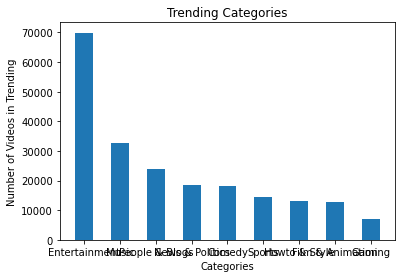

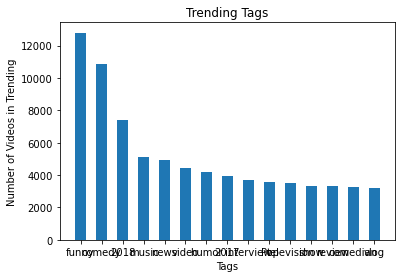

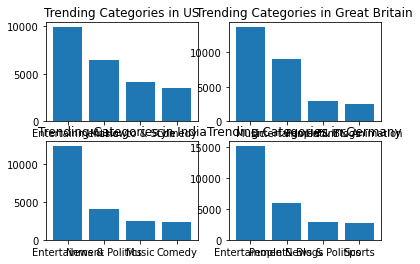

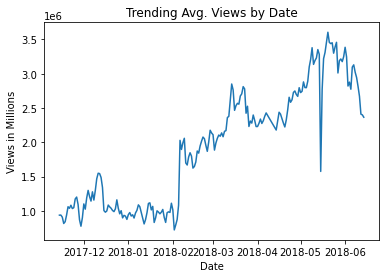

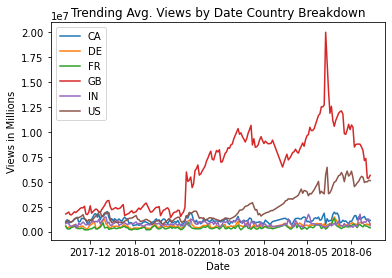

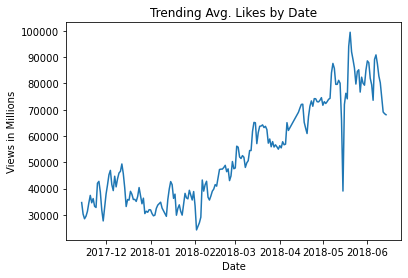

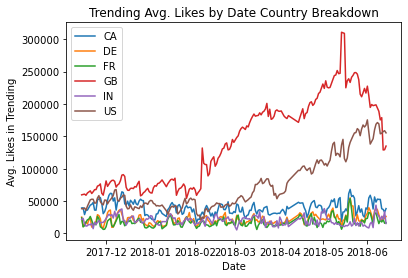

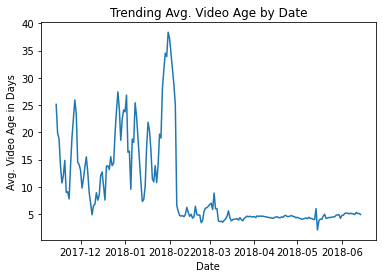

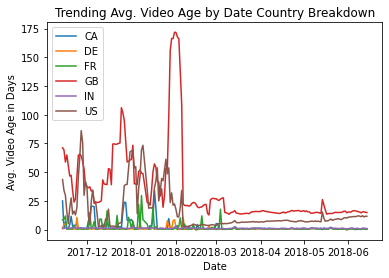

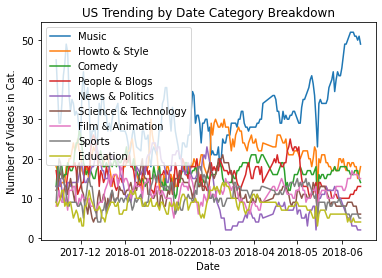

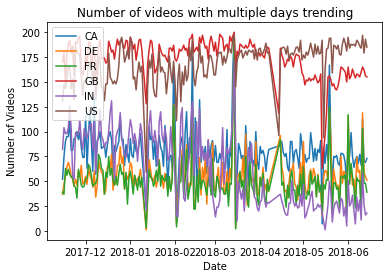

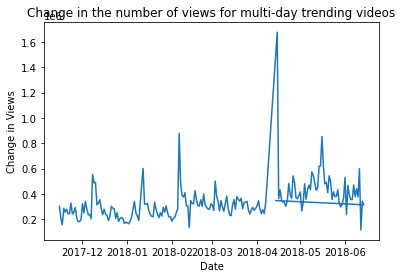

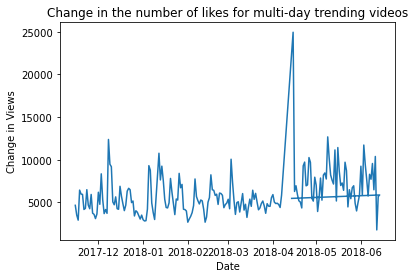

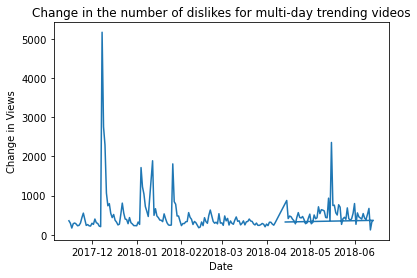

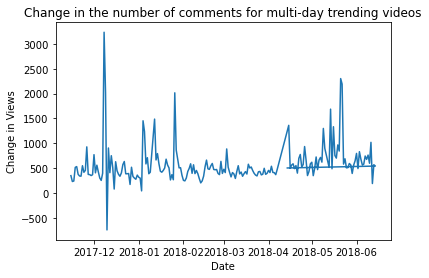

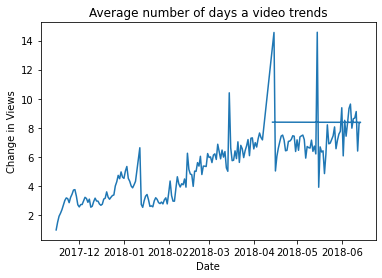

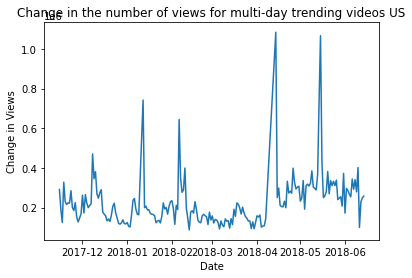

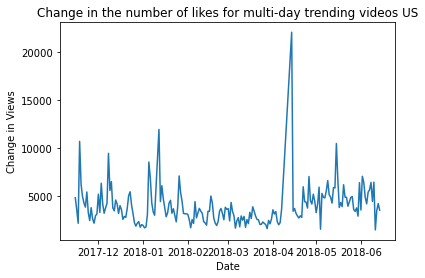

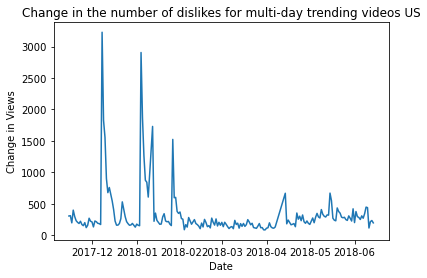

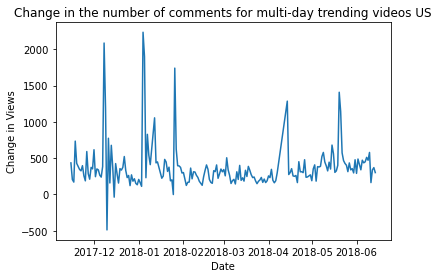

In [6]:
################################################################################
# Initial own visualizations and analsyis                                      #
################################################################################

# There are multiple types of visualizations that are possible nad helpful in this case, many  of them have to use time as the x axis
# NOTE: for my powerpoint I have adjusted their size by hand, sadly I am still not very effective at using matplotlib for now

# First let's take a look at some obvious things, like average likes for each trending day, have to split this by some countries though possible
# because US like trends might be different than in other areas
# plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
plt.bar(category_breakdown.keys().tolist()[0:9], category_breakdown[0:9], width=0.5)
plt.title("Trending Categories")
plt.xlabel("Categories")
plt.ylabel("Number of Videos in Trending")
plt.show()

# Just going to look at the commonly used tags
plt.bar(common_tags['index'].tolist()[0:15], common_tags[0][0:15], width=0.5)
plt.title("Trending Tags")
plt.xlabel("Tags")
plt.ylabel("Number of Videos in Trending")
plt.show()


# Sample plot now but between different countries
cat_us = trend_pd[ (trend_pd.country_code=="US") ].category.value_counts()
cat_gb = trend_pd[ (trend_pd.country_code=="GB") ].category.value_counts()
cat_in = trend_pd[ (trend_pd.country_code=="IN") ].category.value_counts()
cat_de = trend_pd[ (trend_pd.country_code=="DE") ].category.value_counts()
fig, axs = plt.subplots(2,2)
axs[0][0].bar(cat_us.keys().tolist()[0:4], cat_us[0:4])
axs[0][0].set_title("Trending Categories in US")
axs[0][1].bar(cat_gb.keys().tolist()[0:4], cat_gb[0:4])
axs[0][1].set_title("Trending Categories in Great Britain")
axs[1][0].bar(cat_in.keys().tolist()[0:4], cat_in[0:4])
axs[1][0].set_title("Trending Categories in India")
axs[1][1].bar(cat_de.keys().tolist()[0:4], cat_de[0:4])
axs[1][1].set_title("Trending Categories in Germany")
plt.show()

# Some small but possibly interesting information there on some of the different cateogry breakdowns before

# Let's visualize some trends when it comes to the likes and views overall
plt.plot(trend_pd.trending_date.unique(), trend_pd.groupby("trending_date").views.mean())
plt.title("Trending Avg. Views by Date")
plt.xlabel("Date")
plt.ylabel("Views in Millions")
plt.show()

# Now I am curious if this is going to be different with various countries as well, some outliers due to other countries
for country_code in trend_pd.country_code.unique().tolist():
    plt.plot(trend_pd.trending_date[ trend_pd.country_code==country_code ].unique(), trend_pd[ (trend_pd.country_code==country_code) ].groupby("trending_date").views.mean(), label=country_code)

plt.title("Trending Avg. Views by Date Country Breakdown")
plt.xlabel("Date")
plt.ylabel("Views in Millions")
plt.legend(loc='upper left')
plt.show()

plt.plot(trend_pd.trending_date.unique(), trend_pd.groupby("trending_date").likes.mean())
plt.title("Trending Avg. Likes by Date")
plt.xlabel("Date")
plt.ylabel("Views in Millions")
plt.show()

for country_code in trend_pd.country_code.unique().tolist():
    plt.plot(trend_pd.trending_date[ trend_pd.country_code==country_code ].unique(), trend_pd[ (trend_pd.country_code==country_code) ].groupby("trending_date").likes.mean(), label=country_code)

plt.title("Trending Avg. Likes by Date Country Breakdown")
plt.xlabel("Date")
plt.ylabel("Avg. Likes in Trending")
plt.legend(loc='upper left')
plt.show()

plt.plot(trend_pd.trending_date.unique(), trend_pd.groupby("trending_date").video_age_days.mean())
plt.title("Trending Avg. Video Age by Date")
plt.xlabel("Date")
plt.ylabel("Avg. Video Age in Days")
plt.show()

for country_code in trend_pd.country_code.unique().tolist():
    plt.plot(trend_pd.trending_date[ trend_pd.country_code==country_code ].unique(), trend_pd[ (trend_pd.country_code==country_code) ].groupby("trending_date").video_age_days.mean(), label=country_code)

plt.title("Trending Avg. Video Age by Date Country Breakdown")
plt.xlabel("Date")
plt.ylabel("Avg. Video Age in Days")
plt.legend(loc='upper left')
plt.show()

for category in trend_pd[trend_pd.country_code=="US"].groupby("category").size().sort_values(ascending=False).index.tolist()[1:10]:
    plt.plot(trend_pd.trending_date[ (trend_pd.country_code=="US") & (trend_pd.category==category) ].unique(), trend_pd[ (trend_pd.country_code=="US") & (trend_pd.category==category) ].groupby("trending_date").size(), label=category)

plt.title("US Trending by Date Category Breakdown")
plt.xlabel("Date")
plt.ylabel("Number of Videos in Cat.")
plt.legend(loc='upper left')
plt.show()


# Let's take a quick look at the number of trend videos that are there for more than one day over time broken up by country
for country_code in trend_pd.country_code.unique().tolist():
    tmp_pd = trend_pd[ (trend_pd.country_code==country_code) & (trend_pd.days_trending!=0) ].groupby("trending_date").size().reset_index()
    plt.plot(tmp_pd.trending_date, tmp_pd[0], label=country_code)

plt.title("Number of videos with multiple days trending")
plt.xlabel("Date")
plt.ylabel("Number of Videos")
plt.legend(loc='upper left')
plt.show()

# Now going to look at some interesting points like the delta of views for surviving videos
tmp_pd = trend_pd[ (~trend_pd.views_delta.isnull()) ]
plt.plot(tmp_pd.trending_date.unique(), tmp_pd.groupby("trending_date").views_delta.mean())
plt.title("Change in the number of views for multi-day trending videos")
plt.xlabel("Date")
plt.ylabel("Change in Views")
plt.show()

tmp_pd = trend_pd[ (~trend_pd.likes_delta.isnull()) ]
plt.plot(tmp_pd.trending_date.unique(), tmp_pd.groupby("trending_date").likes_delta.mean())
plt.title("Change in the number of likes for multi-day trending videos")
plt.xlabel("Date")
plt.ylabel("Change in Views")
plt.show()

tmp_pd = trend_pd[ (~trend_pd.dislikes_delta.isnull()) ]
plt.plot(tmp_pd.trending_date.unique(), tmp_pd.groupby("trending_date").dislikes_delta.mean())
plt.title("Change in the number of dislikes for multi-day trending videos")
plt.xlabel("Date")
plt.ylabel("Change in Views")
plt.show()

tmp_pd = trend_pd[ (~trend_pd.comment_count_delta.isnull()) ]
plt.plot(tmp_pd.trending_date.unique(), tmp_pd.groupby("trending_date").comment_count_delta.mean())
plt.title("Change in the number of comments for multi-day trending videos")
plt.xlabel("Date")
plt.ylabel("Change in Views")
plt.show()

tmp_pd = trend_pd[ (trend_pd.days_trending!=0) ]
plt.plot(tmp_pd.trending_date.unique(), tmp_pd.groupby("trending_date").days_trending.mean())
plt.title("Average number of days a video trends")
plt.xlabel("Date")
plt.ylabel("Change in Views")
plt.show()


# There is some facinating bump in the past where something drastically has changed and there is some odd fluctuation around the time in the year for GB content, drill further into US instead
# Now going to look at some interesting points like the delta of views for surviving videos
tmp_pd = trend_pd[ (trend_pd.country_code=="US") & (~trend_pd.views_delta.isnull()) ]
plt.plot(tmp_pd.trending_date.unique(), tmp_pd.groupby("trending_date").views_delta.mean())
plt.title("Change in the number of views for multi-day trending videos US")
plt.xlabel("Date")
plt.ylabel("Change in Views")
plt.show()

tmp_pd = trend_pd[ (trend_pd.country_code=="US") & (~trend_pd.likes_delta.isnull()) ]
plt.plot(tmp_pd.trending_date.unique(), tmp_pd.groupby("trending_date").likes_delta.mean())
plt.title("Change in the number of likes for multi-day trending videos US")
plt.xlabel("Date")
plt.ylabel("Change in Views")
plt.show()

tmp_pd = trend_pd[ (trend_pd.country_code=="US") & (~trend_pd.dislikes_delta.isnull()) ]
plt.plot(tmp_pd.trending_date.unique(), tmp_pd.groupby("trending_date").dislikes_delta.mean())
plt.title("Change in the number of dislikes for multi-day trending videos US")
plt.xlabel("Date")
plt.ylabel("Change in Views")
plt.show()

tmp_pd = trend_pd[ (trend_pd.country_code=="US") & (~trend_pd.comment_count_delta.isnull()) ]
plt.plot(tmp_pd.trending_date.unique(), tmp_pd.groupby("trending_date").comment_count_delta.mean())
plt.title("Change in the number of comments for multi-day trending videos US")
plt.xlabel("Date")
plt.ylabel("Change in Views")
plt.show()


## Conclusion

For the required project work it seems that there is definately some coorelation and even some basic patterns for the number of views in the US video set based on likes, dislikes, etc. However, the model that I created only explained about 68% of the variation, meaning that there are some things I likely have overlooked. One that I recongnize as I am writing this is to remove other outliers based on if they have comments and other features enabled, or perhaps just adding them as classifiers into the model because having those disabled could as well change the number of views a video has.

Again based on the limitations of the data, I wasn't able to bulid the models that I had wanted, but I did get some interesting information based off many datapoints I was able to data-mine out or be able to visualize. It looks as if there was some serious changes in the behavior of the algorithm that chooses trending videos or in user behavior from 2017-12 to 2018-02 for the US and GB. The average number of views of trending videos skyrockets and seems to stay at a very high average onwards. Some of the other datapoints seem to have similar patterns but to less of an extreme, but another interesting trend is that the average age of these trending videos seems to level off and even drop quite dramatically for certain countries.

Another pattern that I did notice during my analysis and the various visualizations is that the deltas in the likes, dislikes,comment counts, and views for those videos that were in trending and stayed in trending the next day. All of them did have some spikes, this wasn't the norm and is likely from certain viral videos, but overall were very steady. This would indicate that there might be a change in these numbers that would likely keep videos in the trending tab. This leads me to naturally want to do a survival analysis. However, that would be difficult since I don't have data on the videos soon as they drop out of the trending tab. If I were able to get this data, a survival analysis may be able to predict if a videos is likely to stay in trending, or when it will eventually drop out of the trending tab.

Lastly I wish I had more time to finish mining a few more datapoints and attaching it to the primary trend_pd dataframe, but it was coming too close to the end of the semester and I needed to at somepoint finish.
